(0.0, 0.1)

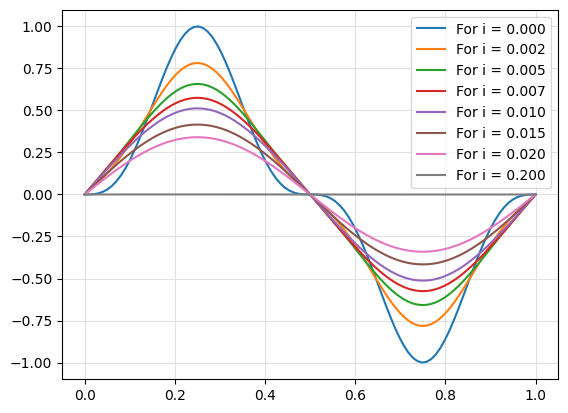

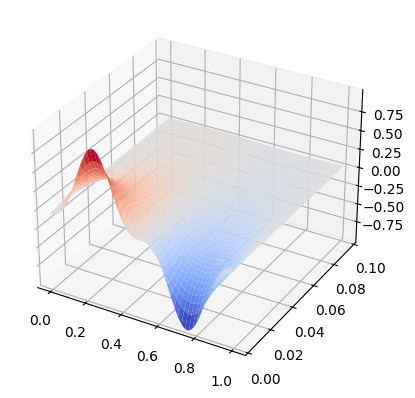

In [44]:
from torch.func import functional_call, grad, vmap, jacrev, hessian
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import math


# problem statement
# init = lambda t, x: (3/4)*torch.sin(2*math.pi*x) - (1/4)*torch.sin(6*math.pi*x)
init = lambda t, x: torch.sin(2*math.pi*x)

solution = lambda t, x: (3/4)*torch.exp((-4)*(math.pi**2)*t)*torch.sin(2*math.pi*x) - (1/4)*torch.exp((-36)*(math.pi**2)*t)*torch.sin(6*math.pi*x)
left_boundary = lambda t, x: 0
right_boundary = lambda t, x: 0



xs = torch.linspace(0, 1, 100)
for i in torch.cat((torch.linspace(0, 0.01, 5), torch.tensor([0.015, 0.02, 0.2]))):
    ys = solution(torch.full_like(xs, i), xs)
    plt.plot(xs, ys, zorder=2, label=f"For i = {i:.3f}")

# ys = solution(xs, torch.full_like(xs, 0.01))
# plt.plot(xs, ys, zorder=2, label=f"For i = {0}")
plt.grid(c='#e1e1e1', zorder=0)
plt.legend()

mesh = 1000

x = torch.linspace(0, 1, mesh)
t = torch.linspace(0, 0.1, mesh)
T, X = torch.meshgrid(t, x)
data = torch.cartesian_prod(t, x)
# cmap = plt.colormaps['Reds'](28)
_, axes = plt.subplots(1, subplot_kw={"projection": "3d"})

u = solution(T, X)

# u = u.reshape((mesh, mesh))

axes.plot_surface(X, T, u, cmap=plt.cm.coolwarm)
# for xs in ys_to_plot:
#     line = axes.plot(x_train_1d, xs)
#     # line[0].set_color(color)
axes.set_ylim(0, 0.1)
# axes.set_ylim(-1, 1)

In [62]:
# create class for needed thing
class Approximator(nn.Module):
    def __init__(self, *,
                 num_inputs = 2,
                 num_neurons = 5,
                 num_layers = 3,
                 activation = nn.Tanh(),
                 num_outputs = 1):

        super().__init__()

        start_layer = nn.Linear(num_inputs, num_neurons)
        layers = [start_layer, activation]
        for _ in range(num_layers):
            layers.extend([nn.Linear(num_neurons, num_neurons), activation])

        output_layer = nn.Linear(num_neurons, num_outputs)
        layers.append(output_layer)

        self.network = nn.Sequential(*layers)

    def forward(self, t, x):
        x = self.network(torch.vstack((t, x)).T)
        return torch.squeeze(x)
        # return self.linear2(x)

torch.manual_seed(42);

In [71]:
from torch import autograd
import torchviz
torch.manual_seed(42)


def phys_loss_fn(ts, xs, y_pred):

    first_derivative_t = autograd.grad(y_pred, ts, grad_outputs=torch.ones_like(y_pred), create_graph=True, retain_graph=True)[0]
    first_derivative_x = autograd.grad(y_pred, xs, grad_outputs=torch.ones_like(y_pred), create_graph=True, retain_graph=True)[0]
    # We now have dloss/dx
    second_derivative_x = autograd.grad(first_derivative_x, xs, grad_outputs=torch.ones_like(first_derivative_x), create_graph=True, retain_graph=True)[0]

    dudt = first_derivative_t
    duudxx = second_derivative_x

    delta_equation = dudt - duudxx
    loss_torch = nn.MSELoss()
    return loss_torch(delta_equation, torch.zeros_like(delta_equation))




# model
# model = Approximator(num_neurons = 128, activation = nn.Sigmoid())
model = Approximator(num_neurons = 128)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
loss_outer = nn.MSELoss()

# data for inner
t_train = torch.rand(300, requires_grad=True)
x_train = torch.rand(300, requires_grad=True)
# x_train = torch.cartesian_prod(x_train_1d_t, x_train_1d)
# x_train = torch.stack((x_train_1d_t, x_train_1d)).T
# x_train.requires_grad = True
# print(x_train[:5])

# data in init
x_train_init = torch.linspace(0, 1, 20)
t_train_init = torch.zeros_like(x_train_init)
# x_train_init = torch.stack((torch.zeros_like(x_train_init_1d), x_train_init_1d)).T
y_train_init = init(t_train_init, x_train_init)
# print(x_train_init[:5])
# print(y_train_init[:5])

# data in left boundary
x_train_left = torch.linspace(0, 1, 20)
t_train_left = torch.full_like(x_train_left, 0)
y_train_left = torch.full_like(x_train_left, 0)
# print(x_train_left[:5])
# print(y_train_left[:5])

# data in right boundary
x_train_right = torch.linspace(0, 1, 20)
t_train_right = torch.full_like(x_train_right, 0)
y_train_right = torch.full_like(x_train_right, 1)
# print(x_train_right[:5])
# print(y_train_right[:5])
# x_train = x_train.T

# all MSE loss
# x_train_mse = torch.cat((x_train_init, torch.cat((x_train_left, x_train_right))))
# print(x_train_mse.shape)
# y_train_mse = torch.cat((y_train_init, torch.cat((y_train_left, y_train_right))))
# print(y_train_mse.shape)

epochs = 5000

for epoch in range(epochs):
    model.train()

    y_pred_inner = model(t_train, x_train)
    # y_pred_mse = model(x_train_mse)
    y_pred_init = model(t_train_init, x_train_init)
    y_pred_left = model(t_train_left, x_train_left)
    y_pred_right = model(t_train_right, x_train_right)


    loss_phys = phys_loss_fn(t_train, x_train, y_pred_inner)
    # loss_mse = loss_outer(y_pred_mse, y_train_mse)
    loss_init = loss_outer(y_pred_init, y_train_init)
    loss_left = loss_outer(y_pred_left, y_train_left)
    loss_right = loss_outer(y_pred_right, y_train_right)

    loss = 30*loss_init + loss_phys  + 4*loss_left + 4*loss_right
    # im = torchviz.make_dot(loss, params=dict(model.named_parameters()))
    # loss = 20*loss_mse + loss_phys
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


    if epoch % (epochs/10) == 0:
        print(f'Loss phys: {loss_phys:.8f}| loss left: {loss_left:.8f} | loss right: {loss_right:.8f} | loss init: {loss_init:.8f} | Total: {loss}')
        # print(f'Loss phys: {loss_phys:.8f}| loss left: {loss_mse:.8f} | Total: {loss}')
        # with torch.inference_mode():
            # y_pred = model(x_train)
            # _, axes = plt.subplots(1)
            # axes.scatter(x_train_init_1d, y_train_init, c='red')
            # axes.scatter(x_train[:, 1].detach(), y_pred.detach(), label=f'Epoch: {epoch}', alpha = 0.5)
            # axes.set_xlim(0, 1)
            # axes.set_ylim(-1, 1)
            # axes.legend()

# im

Loss phys: 0.00020732| loss left: 0.19518116 | loss right: 0.96884888 | loss init: 0.29581288 | Total: 8.874592781066895
Loss phys: 0.01622239| loss left: 0.19518116 | loss right: 0.96884888 | loss init: 0.00105316 | Total: 0.04781705141067505
Loss phys: 0.63235098| loss left: 0.19518116 | loss right: 0.96884888 | loss init: 0.14663000 | Total: 5.031250953674316
Loss phys: 0.00710918| loss left: 0.19518116 | loss right: 0.96884888 | loss init: 0.05240047 | Total: 1.5791232585906982
Loss phys: 0.09463367| loss left: 0.19518116 | loss right: 0.96884888 | loss init: 0.11372802 | Total: 3.506474256515503
Loss phys: 0.06140769| loss left: 0.19518116 | loss right: 0.96884888 | loss init: 0.04150309 | Total: 1.3065005540847778
Loss phys: 0.18169321| loss left: 0.19518116 | loss right: 0.96884888 | loss init: 0.05521359 | Total: 1.8381009101867676
Loss phys: 0.01190044| loss left: 0.19518116 | loss right: 0.96884888 | loss init: 0.00234593 | Total: 0.08227843046188354
Loss phys: 0.02166929| lo

(-1.0, 1.0)

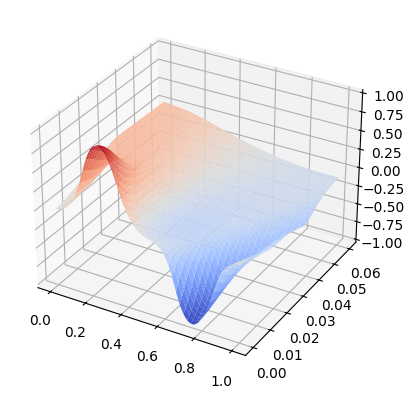

In [72]:
# ys_to_plot = y_pred.detach()
# ys_to_plot = ys_to_plot.reshape(28, 28)
mesh = 1000

x = torch.linspace(0, 1, mesh)
t = torch.linspace(0, 0.06, mesh)
T, X = torch.meshgrid(t, x)
# data = torch.cartesian_prod(t, x)
# cmap = plt.colormaps['Reds'](28)
_, axes = plt.subplots(1, subplot_kw={"projection": "3d"})

with torch.inference_mode():
    u = model(T.flatten(), X.flatten())

u = u.reshape((mesh, mesh))

axes.plot_surface(X, T, u, cmap=plt.cm.coolwarm)
# for xs in ys_to_plot:
#     line = axes.plot(x_train_1d, xs)
#     # line[0].set_color(color)
axes.set_zlim(-1, 1)
# axes.set_ylim(-1, 1)



In [2]:
import sympy as smp
import torch

In [6]:
import math
from scipy import special

x = smp.Symbol("x")
t = smp.Symbol("t")


str = 'sin(t + x)*sin(t!)'
# str = 'x + t'

fn2 = smp.parsing.sympy_parser.parse_expr(str)

fn = smp.lambdify((x, t), fn2, {"sin":torch.sin,
                                "factorial":lambda x: torch.exp(torch.lgamma(x+1))})

smp.printing.latex(fn2)


'\\sin{\\left(t + x \\right)} \\sin{\\left(t! \\right)}'

In [24]:
# Define symbolic variables
# n, x = smp.symbols('n x')

# Define a symbolic expression with an infinite sum
# expr = smp.Sum(x**n / smp.factorial(n), (n, 0, smp.oo))  # This represents the Taylor series for exp(x)

# Approximate the infinite sum with a finite sum up to N terms
N = 10  # Number of terms to approximate the infinite sum

# class EndlSum(smp.Function):
#     @classmethod
#     def eval(cls, f, n):
    
#         N = 10
#         # fn = smp.sympify(f)
    
#         fn2 = smp.Add([f(i) for i in range(1, N)])
    
#         return fn2

expr_approx = "x + n"


x = smp.Symbol('x')
n = smp.Symbol('n')
# Convert the approximated expression to a PyTorch callable function
obj = smp.parsing.sympy_parser.parse_expr(expr_approx)
obj = obj.subs(smp.Add, smp.Mul)
expr_torch = smp.utilities.lambdify((x, n), obj, {#"EndlSum": EndlSum,
                                                  "sin":torch.sin,
                                                  "factorial":lambda x: torch.exp(torch.lgamma(x+1))})

# # Create a PyTorch tensor as input
x_tensor = torch.tensor([1.0, 2.0, 3.0])

# # Evaluate the approximated expression using PyTorch tensors
# result = expr_torch(x_tensor, torch.tensor(1))
# print(result)

obj

TypeError: as_coeff_Add() missing 1 required positional argument: 'self'

In [5]:
import torch
# problem statement
init = lambda t, x: (3/4)*torch.sin(2*math.pi*x) - (1/4)*torch.sin(6*math.pi*x)
# init = lambda t, x: torch.sin(2*math.pi*x)

solution = lambda t, x: (3/4)*torch.exp((-4)*(math.pi**2)*t)*torch.sin(2*math.pi*x) - (1/4)*torch.exp((-36)*(math.pi**2)*t)*torch.sin(6*math.pi*x)
left_boundary = lambda t, x: torch.tensor(0)
right_boundary = lambda t, x: torch.tensor(0)


In [10]:
a = torch.tensor([1, 2, 3])
b = torch.tensor([1, 2, 5])

re = torch.vmap(left_boundary)

re(a, b)

tensor([0, 0, 0])

In [1]:
strings = '    '
strings.strip()

''

In [19]:


import sympy as smp
from typing import Dict

def validate_input_dict(input_dict: Dict) -> None:
    """
    Validate the input dictionary against the specified requirements.

    Args:
        input_dict (Dict[str, str]): A dictionary with the following keys:
            'coefficient', 'left-x', 'right-x', 'end-t', 'init-boundary', 'left-boundary', 'right-boundary'
            All values in the dictionary are strings.

    Raises:
        ValueError: If any of the validation checks fail.

    Returns:
        None
    """
    t, x = smp.symbols('t x')

    # Check 'coefficient', 'left-x', and 'right-x' for float values
    for key in ['coefficient', 'left-x', 'right-x']:
        value = input_dict.get(key)
        if value is not None:
            try:
                float_value = float(value)
            except ValueError:
                raise ValueError(f"The value for '{key}' is not a valid float.")
        else:
            raise ValueError(f"The value for '{key}' can not be None.")
            
    if input_dict['left-x'] > input_dict['right-x']:
        raise ValueError(f'Left x {input_dict["left-x"]} should be less than right x {input_dict["right-x"]}')

    # Check 'end-t' for positive float value
    end_t_value = input_dict.get('end-t')
    if end_t_value is not None:
        try:
            end_t = float(end_t_value)
            if end_t <= 0:
                raise ValueError("The value for 'end-t' must be a positive float or None.")
        except ValueError:
            raise ValueError("The value for 'end-t' is not a valid float.")
    else:
        raise ValueError(f"The value for 'end-t' can not be None.")

    if input_dict.get('init-boundary') is None:
        raise ValueError(f"The value for initial condition can not be None.")
    
    # Check other keys for valid SymPy expressions
    for key in ['init-boundary', 'left-boundary', 'right-boundary']:
        value = input_dict.get(key)
        if value is not None:
            try:
                expr = smp.parsing.sympy_parser.parse_expr(value)
                lambdified_expr = smp.utilities.lambdify([t, x], expr)
                _ = lambdified_expr(3, 4)
            except (SyntaxError, TypeError, ValueError):
                raise ValueError(f"The value for '{key}' is not a valid SymPy expression.")

    print("Input dictionary is valid.")


# Valid input
valid_input = {
    'coefficient': '1.0',
    'left-x': '0.0',
    'right-x': '1.0',
    'end-t': '1.0',
    'init-boundary': 'sin(x)',
    'left-boundary': '0',
    'right-boundary': '0'
}
validate_input_dict(valid_input)  # Output: Input dictionary is valid.

# Invalid input
invalid_input = {
    'coefficient':'1',
    'left-x': '2',
    'right-x': '5',
    'end-t': '1.0',
    'init-boundary': None,
    'left-boundary': None,
    'right-boundary': '0'
}
validate_input_dict(invalid_input)  # Raises ValueError

Input dictionary is valid.


ValueError: The value for initial condition can not be None.

In [1]:
float('fghjm')

ValueError: could not convert string to float: 'fghjm'